# STEP 1: Install and Import libraries

In [ ]:
!pip install stanza nltk pyarabic

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from typing import List
from urllib.parse import urljoin
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# STEP 2: Data collection (Web Scraping)

In [2]:
class ArabicTextScraper:
    """
    Scalable Arabic text crawler for news articles
    Topic: Technology
    """

    def __init__(self, sleep_time=1.0):
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
        }
        self.data = []
        self.visited_urls = set()
        self.sleep_time = sleep_time

    # Arabic detector
    def _is_arabic(self, text: str) -> bool:
        return bool(re.search(r"[\u0600-\u06FF]", text))

    # Extract article links from section page
    def _get_article_links(self, soup, base_url):
        links = set()
        for a in soup.find_all("a", href=True):
            href = a["href"]
            full_url = urljoin(base_url, href)

            if (
                full_url.startswith(base_url)
                and len(full_url) > 40
                and full_url not in self.visited_urls
            ):
                links.add(full_url)

        return list(links)

    # Scrape full article page
    def _scrape_article_page(self, url):
        try:
            response = requests.get(url, headers=self.headers, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")

            paragraphs = soup.find_all("p")
            text = " ".join(p.get_text(strip=True) for p in paragraphs)

            if self._is_arabic(text) and len(text) > 300:
                return text

        except Exception:
            pass

        return None

    # Crawl Al Jazeera Arabic – Technology
    def scrape_aljazeera_tech(self, max_pages=10):
        base_url = "https://www.aljazeera.net/technology"

        for page in range(1, max_pages + 1):
            page_url = f"{base_url}?page={page}"
            print(f"[+] Al Jazeera page {page}")

            try:
                response = requests.get(page_url, headers=self.headers, timeout=10)
                soup = BeautifulSoup(response.content, "html.parser")

                article_links = self._get_article_links(soup, base_url)

                for link in article_links:
                    if link in self.visited_urls:
                        continue

                    self.visited_urls.add(link)
                    text = self._scrape_article_page(link)

                    if text:
                        self.data.append({
                            "text": text,
                            "source": "aljazeera",
                            "topic": "technology"
                        })

                    time.sleep(self.sleep_time)

            except Exception as e:
                print(f"[!] Page error: {e}")

    # Crawl BBC Arabic
    def scrape_bbc_arabic(self, max_pages=10):
        base_url = "https://www.bbc.com/arabic"

        for page in range(1, max_pages + 1):
            page_url = f"{base_url}?page={page}"
            print(f"[+] BBC Arabic page {page}")

            try:
                response = requests.get(page_url, headers=self.headers, timeout=10)
                soup = BeautifulSoup(response.content, "html.parser")

                article_links = self._get_article_links(soup, base_url)

                for link in article_links:
                    if link in self.visited_urls:
                        continue

                    self.visited_urls.add(link)
                    text = self._scrape_article_page(link)

                    if text:
                        self.data.append({
                            "text": text,
                            "source": "bbc_arabic",
                            "topic": "news"
                        })

                    time.sleep(self.sleep_time)

            except Exception as e:
                print(f"[!] Page error: {e}")

    # Assign relevance scores (0–10)
    def assign_relevance_scores(self):
        tech_keywords = [
            "تقنية", "ذكاء", "اصطناعي", "سيبراني", "ثغرة",
            "برمجة", "تشفير", "هجوم", "امن", "شبكة"
        ]

        for item in self.data:
            score = 4.5
            text = item["text"]

            if len(text) > 800:
                score += 2.0
            elif len(text) > 400:
                score += 1.5
            elif len(text) > 200:
                score += 1.0

            keyword_hits = sum(1 for kw in tech_keywords if kw in text)
            score += min(keyword_hits * 0.4, 2.5)

            if item["source"] == "aljazeera":
                score += 1.0
            elif item["source"] == "bbc_arabic":
                score += 0.5

            item["score"] = min(max(score, 0), 10)

    # Create final dataset
    def create_dataset(self, output_file="arabic_dataset.csv"):
        df = pd.DataFrame(self.data)
        df = df[["text", "score"]]
        df = df.drop_duplicates(subset=["text"])
        df = df.reset_index(drop=True)

        df.to_csv(output_file, index=False, encoding="utf-8-sig")
        print(f"[✓] Dataset created: {len(df)} samples")
        print(f"[✓] Saved to {output_file}")

        return df

In [ ]:
scraper = ArabicTextScraper(sleep_time=1.0)

scraper.scrape_aljazeera_tech(max_pages=15)
scraper.scrape_bbc_arabic(max_pages=15)

scraper.assign_relevance_scores()

df = scraper.create_dataset("arabic_tech_dataset.csv")
df.head()


[+] Al Jazeera page 1
[+] Al Jazeera page 2
[+] Al Jazeera page 3
[+] Al Jazeera page 4
[+] Al Jazeera page 5
[+] Al Jazeera page 6
[+] Al Jazeera page 7
[+] Al Jazeera page 8
[+] Al Jazeera page 9
[+] Al Jazeera page 10
[+] Al Jazeera page 11
[+] Al Jazeera page 12
[+] Al Jazeera page 13
[+] Al Jazeera page 14
[+] Al Jazeera page 15
[+] BBC Arabic page 1
[+] BBC Arabic page 2


# STEP 2: PREPROCESSING PIPELINE

In [4]:
import re
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-12-18 09:59:32.079060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-18 09:59:32.079120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-18 09:59:32.081360: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
class ArabicPreprocessor:
    """
    Pipeline for Arabic deep learning:
    - Normalization
    - Cleaning
    - Tokenization
    - Stopword removal
    ps: Several stemming strategies were evaluated, including root-based 
    and light stemming. 
    However, both approaches introduced semantic degradation in Arabic text. 
    Therefore, stemming was excluded, and only normalization, tokenization, 
    and stopword removal were applied to preserve contextual 
    meaning for deep learning models.
    """

    def __init__(self):
        self.stop_words = self._load_stopwords()

        self.arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!"…"–'''
        self.english_punctuations = '''`-=~!@#$%^&*()_+[]{}|;:'",.<>?/'''
        self.all_punctuations = self.arabic_punctuations + self.english_punctuations

    def _load_stopwords(self):
        return {
            'في', 'من', 'إلى', 'على', 'هذا', 'هذه', 'ذلك', 'التي', 'الذي',
            'أن', 'قد', 'لم', 'كان', 'يكون', 'ما', 'لا', 'نحو', 'بعض',
            'كل', 'هو', 'هي', 'أو', 'عن', 'عند', 'منذ', 'حتى', 'أي',
            'كما', 'بين', 'إذا', 'كيف', 'أين', 'متى', 'لماذا', 'ليس'
        }

    def normalize_arabic(self, text):
        text = re.sub("[إأآا]", "ا", text)
        text = re.sub("ى", "ي", text)
        text = re.sub("ؤ", "و", text)
        text = re.sub("ئ", "ي", text)
        text = re.sub("ة", "ه", text)

        arabic_diacritics = re.compile("""
            ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ
        """, re.VERBOSE)

        text = re.sub(arabic_diacritics, '', text)
        return text

    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', self.all_punctuations))

    def remove_english_chars(self, text):
        text = re.sub(r'[a-zA-Z]', '', text)
        text = re.sub(r'\d+', '', text)
        return text

    def tokenize(self, text):
        return text.split()

    def remove_stopwords(self, tokens):
        return [t for t in tokens if t not in self.stop_words]

    def preprocess_text(self, text):
        text = str(text).strip()
        text = self.normalize_arabic(text)
        text = self.remove_english_chars(text)
        text = self.remove_punctuation(text)
        text = ' '.join(text.split())

        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        tokens = [t for t in tokens if len(t) > 2]

        return ' '.join(tokens)

In [6]:
# Apply preprocessing
preprocessor = ArabicPreprocessor()
df['text_clean'] = df['text'].apply(preprocessor.preprocess_text)

print("Sample preprocessing results:")
for i in range(3):
    print(f"\nOriginal:  {df['text'].iloc[i][:300]}...")
    print(f"Processed: {df['text_clean'].iloc[i][:300]}...")


Sample preprocessing results:

Original:  أغلقت “غوغل” ثغرتين أمنيتين تؤثران على نظام “أندرويد” بدءا من الإصدار 13 وحتى الإصدار 16، مؤكدة استغلال الثغرات سابقا في مجموعة من الهجمات السيبرانية. رغم التطور الكبير الذي شهده سوق كاميرات الويب الخارجية، وتوفر نماذج قادرة على التصوير بدقة تصل إلى “4K”، فإن الإقبال عليها لا يزال محدودا. ومن هنا، ي...
Processed: اغلقت “غوغل” ثغرتين امنيتين توثران علي نظام “اندرويد” بدءا الاصدار وحتي الاصدار موكده استغلال الثغرات سابقا مجموعه الهجمات السيبرانيه رغم التطور الكبير شهده سوق كاميرات الويب الخارجيه وتوفر نماذج قادره علي التصوير بدقه تصل الي فان الاقبال عليها يزال محدودا ومن هنا يبرز استخدام كاميرا الهاتف الذكي كح...

Original:  صدر الصورة،Oscar Pictures/Film Clinic/General Entertainment Authority/Riyad Season/Bigtime Funds/Mona Zaki Official Facebook Page-Synergy Films/Films Square/Luxor لم يلبث فريق عمل الفيلم المصري "الست" أنْ عرَض الإعلان الترويجي للفيلم الذي يجسّد حياة "كوكب الشرق"، أم كلثوم، التي تقوم بدور شخصيتها الف...
Processed: صدر الصوره ي

In [7]:
# Discretize scores
df['score_category'] = pd.cut(
    df['score'], bins=3, labels=['low', 'medium', 'high']
)

df['score_label'] = pd.cut(
    df['score'], bins=3, labels=[0, 1, 2]
)

print("\n✓ Preprocessing complete")
print("Score distribution:")
print(df['score_category'].value_counts())



✓ Preprocessing complete
Score distribution:
score_category
medium    61
low        8
high       3
Name: count, dtype: int64


In [8]:
# Save preprocessed data
df.to_csv(
    'arabic_dataset_preprocessed.csv',
    index=False,
    encoding='utf-8-sig'
)


# STEP 4: Preparw data for training

In [9]:
MAX_WORDS = 10000     # for articles
MAX_LEN = 200         # long sequences
EMBEDDING_DIM = 128
BATCH_SIZE = 8
EPOCHS = 30

In [10]:
# Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_clean'])

sequences = tokenizer.texts_to_sequences(df['text_clean'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')
y = df['score'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("✓ Data prepared for training")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")
print(f"Vocabulary size: {min(MAX_WORDS, len(tokenizer.word_index))}")


✓ Data prepared for training
Training samples: 45
Validation samples: 12
Test samples: 15
Vocabulary size: 10000


# STEP 5: Build and train models

In [12]:
def build_simple_rnn():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [13]:
def build_bidirectional_rnn():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        Bidirectional(SimpleRNN(64)),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [14]:
def build_gru():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        GRU(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model


In [15]:
def build_lstm():
    model = Sequential([
        Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
        LSTM(64),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model


In [16]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6
    )
]


In [17]:
#Train all models
models = {}
histories = {}

model_builders = {
    'Simple_RNN': build_simple_rnn,
    'Bidirectional_RNN': build_bidirectional_rnn,
    'GRU': build_gru,
    'LSTM': build_lstm
}

for name, builder in model_builders.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}\n")

    model = builder()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    models[name] = model
    histories[name] = history
    print(f"\n✓ {name} training complete")



Training Simple_RNN

Epoch 1/30
6/6 [==============================] - 2s 114ms/step - loss: 48.9496 - mae: 6.9773 - val_loss: 38.6422 - val_mae: 6.2054 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 0s 55ms/step - loss: 30.1618 - mae: 5.4542 - val_loss: 25.1942 - val_mae: 5.0037 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 0s 58ms/step - loss: 18.4369 - mae: 4.2190 - val_loss: 15.6591 - val_mae: 3.9138 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 0s 59ms/step - loss: 11.7057 - mae: 3.2515 - val_loss: 9.1043 - val_mae: 2.9433 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 0s 55ms/step - loss: 7.0143 - mae: 2.4017 - val_loss: 5.9081 - val_mae: 2.3327 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - 0s 54ms/step - loss: 4.0810 - mae: 1.6988 - val_loss: 3.2636 - val_mae: 1.6776 - lr: 0.0010
Epoch 7/30
6/6 [==============================] - 0s 55ms/step - loss: 2.6603 - mae: 1.1873 - val_loss: 1.4616 - val_m

# STEP 6: Evaluation

In [19]:
import numpy as np

In [20]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score
)

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_pred = np.clip(y_pred, 0, 10)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Explained_Var': explained_variance_score(y_test, y_pred)
    }

    results[name] = {
        'predictions': y_pred,
        'metrics': metrics
    }

    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")


Simple_RNN:
  RMSE: 0.8042
  MAE: 0.4878
  R2: -1.3724
  Explained_Var: -0.8667

Bidirectional_RNN:
  RMSE: 0.7090
  MAE: 0.4529
  R2: -0.8439
  Explained_Var: -0.4199

GRU:
  RMSE: 0.7899
  MAE: 0.4756
  R2: -1.2888
  Explained_Var: -0.8440

LSTM:
  RMSE: 0.6115
  MAE: 0.4213
  R2: -0.3717
  Explained_Var: -0.0343


In [21]:
# Create comparison DataFrame
comparison_data = []
for name, result in results.items():
    row = {'Model': name, **result['metrics']}
    comparison_data.append(row)

df_results = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("COMPARISON TABLE")
print("="*80)
print(df_results.to_string(index=False))



COMPARISON TABLE
            Model     RMSE      MAE        R2  Explained_Var
       Simple_RNN 0.804212 0.487790 -1.372353      -0.866682
Bidirectional_RNN 0.709006 0.452910 -0.843904      -0.419946
              GRU 0.789923 0.475612 -1.288800      -0.844036
             LSTM 0.611508 0.421335 -0.371650      -0.034280


# STEP : Visualizations

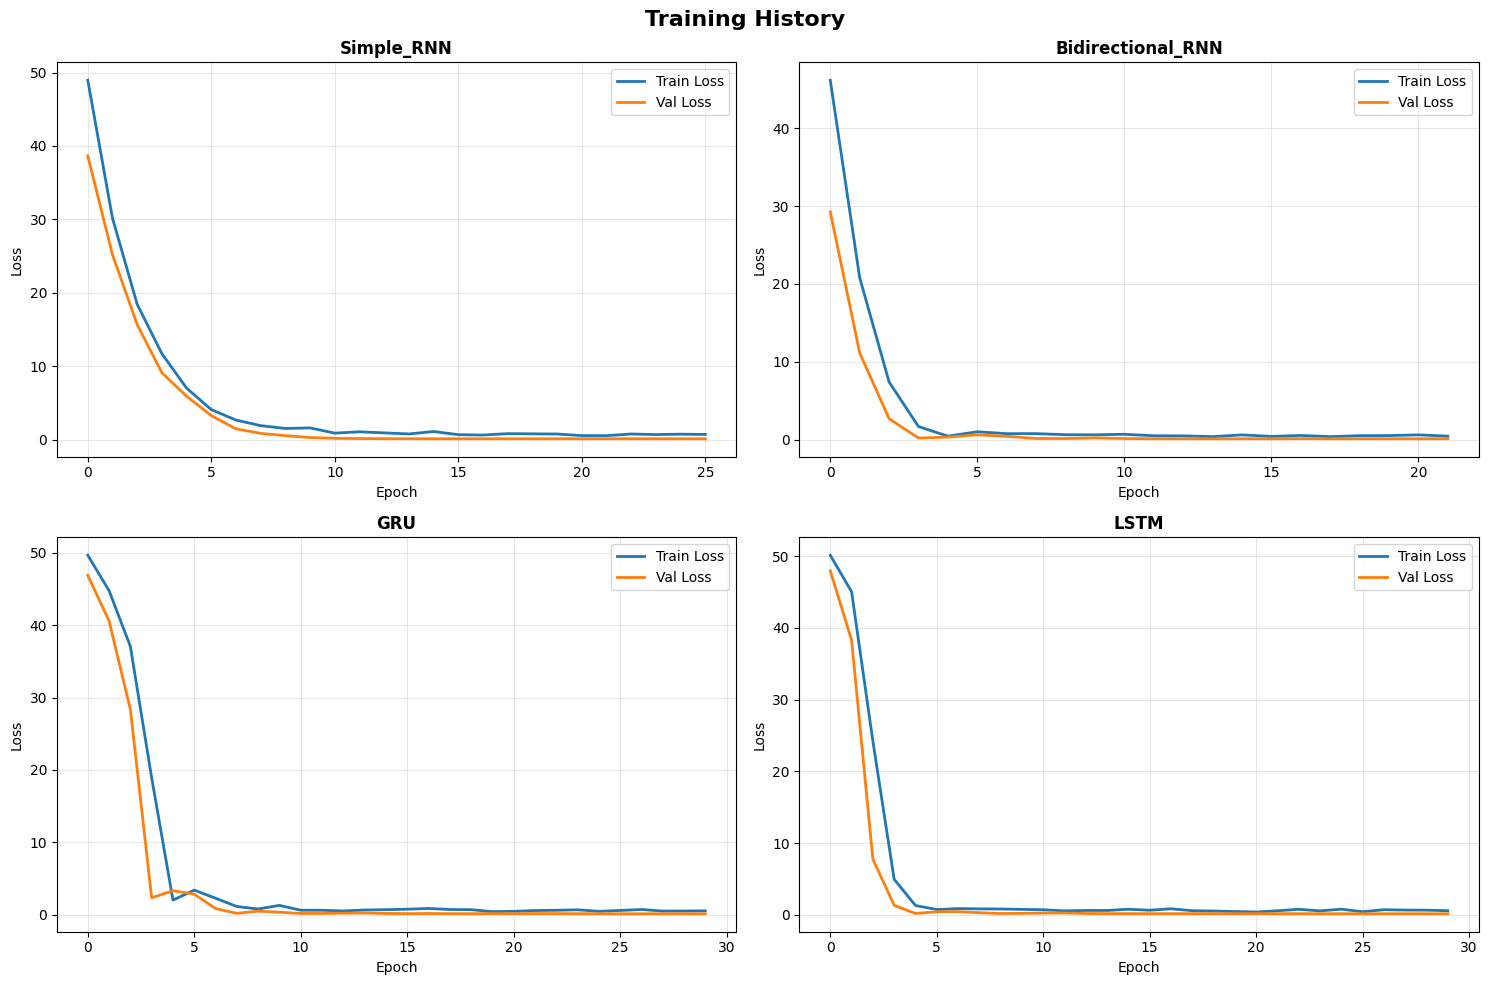

In [24]:
import matplotlib.pyplot as plt

# Training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training History', fontsize=16, fontweight='bold')

for idx, (name, history) in enumerate(histories.items()):
    ax = axes[idx // 2, idx % 2]
    ax.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

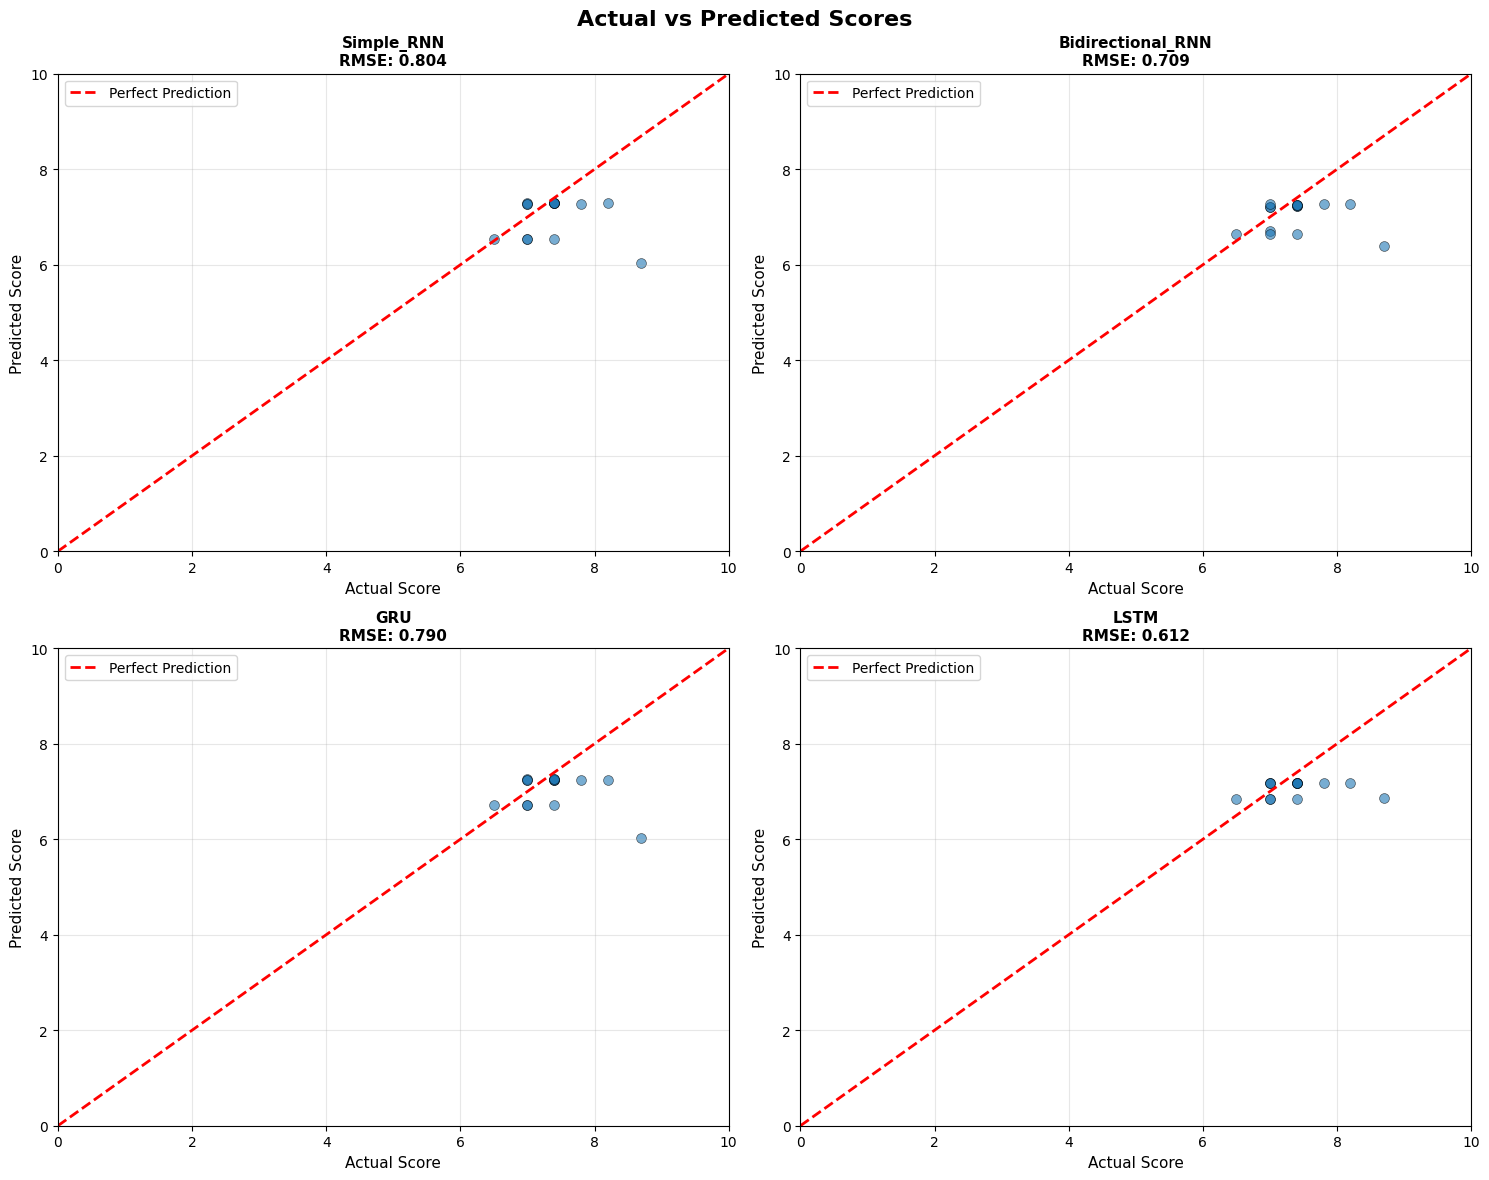

In [25]:
# Predictions comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Actual vs Predicted Scores', fontsize=16, fontweight='bold')

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    y_pred = result['predictions']
    
    ax.scatter(y_test, y_pred, alpha=0.6, s=50, edgecolors='k', linewidth=0.5)
    ax.plot([0, 10], [0, 10], 'r--', linewidth=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Score', fontsize=11)
    ax.set_ylabel('Predicted Score', fontsize=11)
    ax.set_title(f'{name}\nRMSE: {result["metrics"]["RMSE"]:.3f}',
                fontsize=11, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 10])
    ax.set_ylim([0, 10])

plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()